# Case Study PV Review Management

This code is used as a case study example for the paper "Machine and Deep Learning in PhotovoltaicSystems: A Review". Using a Deep Deterministic Policy Gradient model, the idea is to reduce the consumption of energy of a CityLearn environment with one building that has cooling storage control.

In [2]:
import sys
sys.path.append('/Users/jfgf1/Documents/Universidad/Decimo Semesre/Tesis/Tesis Electrica/CityLearn/CityLearn/DDPG_Agent')
from DDPG_Agent.Agent import Agent
import matplotlib.pyplot as plt
import gym
import tensorflow as tf
import numpy as np
from citylearn import  CityLearn
from pathlib import Path
import time
from numpy import save

In [3]:
def plot_learning_curve(x, scores, score_start_history, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg, 'r', label = 'Average Reward')
    plt.vlines(x, 0, scores, linestyles = 'dotted', colors = 'blue' )
    plt.plot(x, scores, 'bo', label = 'Episode Reward' )
    plt.legend(loc = 'lower right')
    plt.title('Episode Reward for EMS using DDPG agent for storage')
    plt.ylabel('Episode Reward')
    plt.xlabel('Episode Number')
    plt.savefig(figure_file)

The building information used for the case study can be seen in the next line of code:

In [4]:
# Central agent controlling one of the buildings using the OpenAI Stable Baselines
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ['Building_4']
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','quadratic']
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, building_ids, buildings_states_actions = building_state_actions, cost_function = objective_function, central_agent = True, verbose = 1)

In [5]:
env.get_building_information()

{'Building_4': {'building_type': 4,
  'climate_zone': 1,
  'solar_power_capacity (kW)': 40,
  'Annual_DHW_demand (kWh)': 0,
  'Annual_cooling_demand (kWh)': 280239.0,
  'Annual_nonshiftable_electrical_demand (kWh)': 36978.9,
  'Correlations_DHW': {},
  'Correlations_cooling_demand': {},
  'Correlations_non_shiftable_load': {}}}

In [9]:
agent = Agent(input_dims = (9,), env=env, n_actions = env.action_space.shape[0],
             max_size = 100000, tau = 0.0003, fc1 = 800, fc2 = 800, batch_size = 1024, noise = 0.1,
             actor_lr = 0.0001, critic_lr = 0.0002, gamma = 0.99) #0.0002 700 400 400 1024
#env.observation_space.shape
n_games = 50
figure_file = 'plots/cityBuild.png'

best_score = env.reward_range[0]
score_history = []
score_start_history = []
load_checkpoint = False
indexes_states = [0, 1, 2, 3, 15, 21, 22, 23, 24]

Cumulated reward: -415.673888266427
.... saving models ....
episode  0 score -415.4 avg score -415.4
Cumulated reward: -293.8032879125011
.... saving models ....
episode  1 score -293.5 avg score -354.5
Cumulated reward: -163.16901558315757
.... saving models ....
episode  2 score -162.9 avg score -290.6
Cumulated reward: -114.03188813328057
.... saving models ....
episode  3 score -113.8 avg score -246.4
Cumulated reward: -111.7272791656177
.... saving models ....
episode  4 score -111.4 avg score -219.4
Cumulated reward: -80.80169540960601
.... saving models ....
episode  5 score -80.5 avg score -196.3
Cumulated reward: -78.47683867472101
.... saving models ....
episode  6 score -78.2 avg score -179.4
Cumulated reward: -24.482719348174925
.... saving models ....
episode  7 score -24.2 avg score -160.0
Cumulated reward: -13.230790862740966
.... saving models ....
episode  8 score -13.0 avg score -143.7
Cumulated reward: 0.7186851396161749
.... saving models ....
episode  9 score 1.0 a

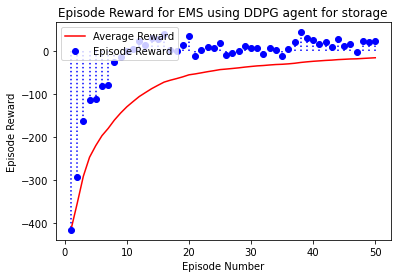

In [6]:


if load_checkpoint:
    n_steps = 0
    while n_steps <= agent.batch_size:
        observation = env.reset()
        observation = [observation[i] for i in indexes_states]
        action = env.action_space.sample()
        observation_, reward, done, info = env.step(action)
        observation_ = [observation_[i] for i in indexes_states]
        agent.remember(observation, action, reward, observation_, done)
        n_steps +=1
    agent.learn()
    agent.load_models()
    evaluate = True
else:
    evaluate = False
    
for i in range(n_games):
    evaluate = False
    observation = env.reset()
    done = False
    score = 0
    j = 0
    agent.noise.reset()
    while j < 4:
        observation, reward, done, info = env.step([0.3])
        j +=1
    observation = [observation[i] for i in indexes_states]
    score_start_history.append(reward)
    while not done:
        action = agent.choose_action(observation, evaluate)
        observation_, reward, done, info = env.step(np.array(action))
        observation_ = [observation_[i] for i in indexes_states]
        score += reward
        agent.remember(observation, action, reward, observation_, done)
        if not load_checkpoint:
            agent.learn()
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()
    print("episode ", i, "score %.1f" % score, 'avg score %.1f' % avg_score)
    
    
x = [i + 1 for i in range(n_games)]
plot_learning_curve(x, score_history, score_start_history, figure_file)

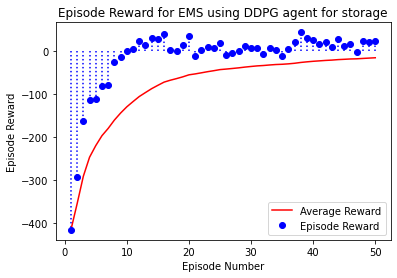

In [19]:
plot_learning_curve(x, score_history, score_start_history, figure_file)

In [22]:
#save('plots/epochs.npy', x)
#save('plots/score_history.npy', score_history)

In [16]:
load_checkpoint = True
observation_ = env.reset()
done = False
counter = []
evaluate = True

if load_checkpoint:
    n_steps = 0
    while n_steps <= agent.batch_size:
        observation = env.reset()
        observation = [observation[i] for i in indexes_states]
        action = env.action_space.sample()
        observation_, reward, done, info = env.step(action)
        observation_ = [observation_[i] for i in indexes_states]
        agent.remember(observation, action, reward, observation_, done)
        n_steps +=1
    agent.learn()
    agent.load_models()
    evaluate = True

j = 0
while j < 4:
    observation_, reward, done, info = env.step([0.3])
    j +=1
observation_ = [observation_[i] for i in indexes_states]

while done==False:
    action = agent.choose_action(observation_, evaluate)
    observation_, reward, done, info = env.step(np.array(action))
    observation_ = [observation_[i] for i in indexes_states]
    #print(observation_[-2])
    #print(action)
    #print(observation_[2])
    #print(reward)
    counter.append(reward)
env.cost()

.... load models ....
Cumulated reward: 230.62251994054574


{'ramping': 1.8005393,
 '1-load_factor': 1.033211776143142,
 'average_daily_peak': 1.3358434,
 'peak_demand': 1.2517856,
 'net_electricity_consumption': 0.9634068,
 'quadratic': 1.2191571,
 'total': 1.2673240020086085}

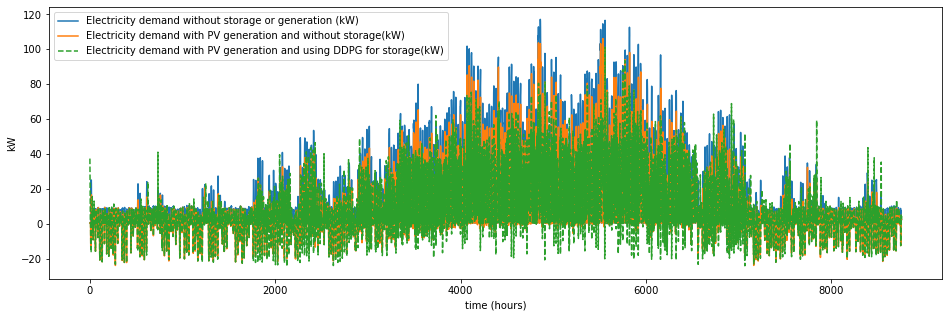

In [14]:
# Plotting winter operation
interval = range(0,8759)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')

plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using DDPG for storage(kW)'])
plt.savefig('plots/profile.png')

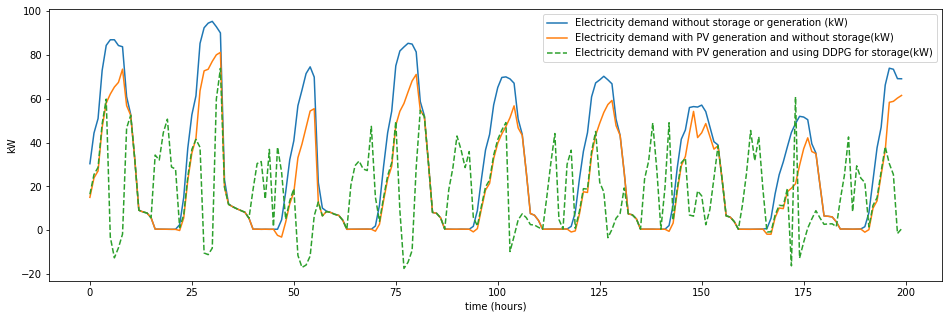

In [15]:
# Plotting winter operation
interval = range(5000,5200)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using DDPG for storage(kW)'])
plt.savefig('plots/profile_interval.png')

In [13]:
print("Electric consumption without central DDPG agent: " + str(np.sum(env.net_electric_consumption_no_storage)) + "W")
print("Electric consumption with central DDPG agent: " + str(np.sum(env.net_electric_consumption)) + "W")

Electric consumption without central DDPG agent: 74536.03W
Electric consumption with central DDPG agent: 62742.605W
